## Ejercicio de Feedback: Clustering

# Introducción y planteamiento del problema

"**Ayuda Internacional**" es una ONG humanitaria internacional comprometida con la lucha contra la pobreza y con proporcionar a las personas de países subdesarrollados servicios básicos y ayuda en tiempos de desastres y calamidades naturales. Esta ONG ha logrado recaudar aproximadamente 10 millones de dólares. Este dinero debe ahora asignarse de manera estratégica y eficaz. Por lo tanto, para decidir la selección de los países que más necesitan ayuda, se deben tomar decisiones basadas en datos.

En consecuencia, resulta necesario **categorizar los países utilizando factores socioeconómicos y de salud** que determinen el desarrollo general de cada país. Basándose en estos grupos de países, definidos por sus condiciones, se distribuirán los fondos para brindar asistencia durante desastres y calamidades naturales. Este es un caso claro de clustering, donde se requiere crear grupos de países basados en las diferentes características presentes.

**Objetivo**:


*   Agrupar países en función de características numéricas socioeconómicas.
*   Determinar qué grupos de países requieren ayuda y en qué grado



## Nuestro conjunto de datos




* **country**: Nombre del país.
* **child_mort**: Muertes de niños menores de 5 años por cada 1000 nacidos vivos.
* **exports**: Exportaciones de bienes y servicios per cápita, expresadas como porcentaje del PIB per cápita.
* **health**: Gasto total en salud per cápita, expresado como porcentaje del PIB per cápita.
* **imports**: Importaciones de bienes y servicios per cápita, expresadas como porcentaje del PIB per cápita.
* **Income**: Ingreso neto por persona.
* **Inflation**: Tasa de crecimiento anual del PIB total.
* **life_expec**: Número promedio de años que un recién nacido viviría si se mantienen los patrones actuales de mortalidad.
* **total_fer**: Número de hijos que nacerían por mujer si las tasas actuales de fertilidad por edad permanecen constantes.
* **gdpp**: PIB per cápita, calculado como el PIB total dividido entre la población total.




## 1 Importación de librerías

In [1]:
#Es posible que necesitéis estas librerías (y muchas más)
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
!pip install -U kaleido
import kaleido
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.cluster import DBSCAN
import seaborn as sns
from matplotlib.colors import ListedColormap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.9 MB/s eta 0:00:00


## 2 Análisis Exploratorio de los datos

**Ejercicio 1** - Llevar a cabo un procedimiento de EDA para obtener información acerca de los datos:

*  Declara el tamaño del dataset y muestra algunos registros por pantalla. Muestra los estadísticos (media, desviación típica, min, max...) relevantes de cada una de las variables. Observando el tipo de características, ¿podemos usarlas todas en un algoritmo de agrupación?

*  Analiza la distribución de cada una de las variables mediante gráficas de densidad y boxplots (se valora utilizar el mínimo código posible para mostrar todas las gráficas). ¿Están bien distribuidas las variables? ¿Qué podemos comentar de este análisis?



In [2]:
# Vamos a cargar los datos e inspeccionar el tamaño y las variables

Datos=pd.read_csv('Country-data.csv')
Datos.shape

(167, 10)

In [3]:
print(Datos.dtypes)

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object


Tenemos 10 variables, de las cuales 9 son numéricas y una es categórica, el país.

In [4]:
# Variables estadísticas básicas

Datos.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


Todas las variables son numéricas, con lo que a priori podriamos usarlas sin problema para realizar un algoritmo de agrupación.

In [5]:
# Vamos a hacer dos bucles que pasen por todas las variables y nos las representen, primero con histogramas y después con boxplots.

# eliminamos la columna country para dejar solo las variables numéricas
Datos_numericos=Datos.drop('country', axis=1)

for i in Datos_numericos.columns:
       fig = go.Figure(data=[go.Histogram(x=Datos[i], histnorm='probability density')])
       fig.update_layout(title_text=i)
       fig.show()

In [6]:
for i in Datos_numericos.columns:
       fig = px.box(Datos, y=i)
       fig.update_layout(title_text=i)
       fig.show()

Podemos ver que las variables siguen distribuciones irregulares, en la mayoría con presencia de outliers(gdpp, life_exp, income, exports o child_mortality). Además resultan distribuciones bastante asimétricas, asemejandose poco a una distribuciónb normal. De entre las gráficas que vemos, podemos observar como gdpp, total_fer, inflation, income y child mortality presentan una asimetría positiva, mientras que life_ecp presenta una simetría negativa. El resto de variables (imports, exports, health) si que parecen tener una cierta distribución normal, pero con presencia de outliers importantes. En conclusión, las variables presentan distribuciones asimétricas y están a distintas escalas, por lo que se necesitarán futuras transformaciones antes de aplicar modelos de agrupación.


## 3 Extracción de las características

**Ejercicio 2** - Realizaremos transformaciones en nuestros datos en crudo para obtener las variables con las que realizar el clustering.

*   Muestra la matriz de correlaciones por pantalla y comenta resumidamente sus conclusiones.

*   Vamos a **agrupar todas nuestras nueve variables en tres grandes indicadores** diferentes: **Salud** (4 variables), **Comercio** (2 variables) y **Finanzas** (3 variables). Definir las agrupaciones en base a lo que significa cada variable. Para construir cada uno de los indicadores, sumaremos cada una de las variables agrupadas en ese indicador dividida por su media (Por ejemplo: Comercio = (variable1/media_variable1) + (variable2/media_variable2)

* Una vez construidos los indicadores, tenemos que asegurarnos que los tres estén a la **misma escala**. Para ello tenemos que decidirnos por la **estandarización** o la **normalización**, ambas funciones nativas de SKLearn. Visualiza la distribución de los 3 grandes indicadores, decide que método emplear (estandarización/normalización) y aplícalo a nuestros datos.






**AYUDA ADICIONAL:**

* La normalización se realiza para características cuyos datos no presentan una distribución normal.

* La estandarización se aplica a características con distribución normal, cuyos valores son muy grandes o muy pequeños en comparación con otras características.


-Matriz de correlación

In [7]:
# Vamosa  utilizar el dataframe sin la columna paises, ya que la matriz de correlación solo soporta variables numéricas

Matriz_correlacion=Datos_numericos.corr()
Matriz_correlacion

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.318093,-0.200402,-0.127211,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,-0.318093,1.000000,-0.114408,0.737381,0.516784,-0.107294,0.316313,-0.320011,0.418725
health,-0.200402,-0.114408,1.000000,0.095717,0.129579,-0.255376,0.210692,-0.196674,0.345966
imports,-0.127211,0.737381,0.095717,1.000000,0.122406,-0.246994,0.054391,-0.159048,0.115498
income,-0.524315,0.516784,0.129579,0.122406,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,0.288276,-0.107294,-0.255376,-0.246994,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,-0.886676,0.316313,0.210692,0.054391,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,0.848478,-0.320011,-0.196674,-0.159048,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,-0.483032,0.418725,0.345966,0.115498,0.895571,-0.221631,0.600089,-0.454910,1.000000


- Primero podemos observar que la mortalidad infantil está relacionada negativamente con todas las variables menos con la tasa de fertilidad y la inflación. Esto es un resultado lógico, ya que todas las variables correlacionadas negativamente son indicadores de países con economías desarrolladas(gdp per capita, importaciones, exportaciones...), mientras que la tasa de fertilidad y la inflación tienden a ser mayores cuanto menos desarrollado esté un país.

- También vemos una correlación de todos los indicadores de país desarrollado que hemos comentado antes (todas las variables menos la mortalidad infantil, fertilidad y la inflación) con las importaciones y con el gdp per capita, el income y la esperanza de vida. Por lo tanto podemos concluir que estas variables tienen una relación positiva muy clara con el desarrollo de un país y el bienestar de su población.

- Un caso curioso resulta el de las exportaciones, que están positivamente correlacionadas con todas las variables asociadas a un país desarrollado menos con la variable health. Esto puede deberse a modelos centrados en exportaciones por parte de países de renta baja, mientras que países desarrollados y muy ricos como EEUU tienden a importar más de lo que exportan. Igualmente, a pesar de esta relación negativa con health, el nivel de exportaciones sigue correlacinando positivamente con el resto de indicadores de desarrollo, y también paradójicamente con la esperanza de vida, por lo que resulta también un indicador de desarrollo claro.

En líneas generales, podemos concluir que las variables mortalidad infantil, fertilidad e inflación tienen una correlación negativa con el desarrollo de un país, mientras el resto de variables tienen una correlación claramente positiva.

-Agrupación de variables

In [8]:
# Definimos las nuevas variables a partir de las originales

Datos['Salud']=Datos['health']/Datos['health'].mean()+Datos['child_mort']/Datos['child_mort'].mean()+Datos['life_expec']/Datos['life_expec'].mean()+Datos['total_fer']/Datos['total_fer'].mean()
Datos['Finanzas']=Datos['gdpp']/Datos['gdpp'].mean()+Datos['income']/Datos['income'].mean()+Datos['inflation']/Datos['inflation'].mean()
Datos['Comercio']=Datos['exports']/Datos['exports'].mean()+Datos['imports']/Datos['imports'].mean()

In [9]:
Datos.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Salud,Finanzas,Comercio
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,6.239852,1.349645,1.200812
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,3.035901,1.471658,1.717580
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,3.389763,3.165367,1.603752
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,6.469020,3.494919,2.430387
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2.964898,2.240150,2.362940


Vamos a ver como están distribuidas estas nuevas variables

Text(0, 0.5, 'Frecuencia')

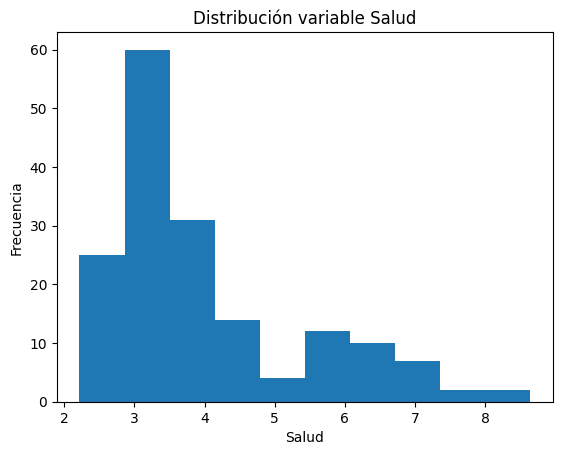

In [10]:
plt.hist(x=Datos['Salud'], bins=10)
plt.title('Distribución variable Salud')
plt.xlabel('Salud')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

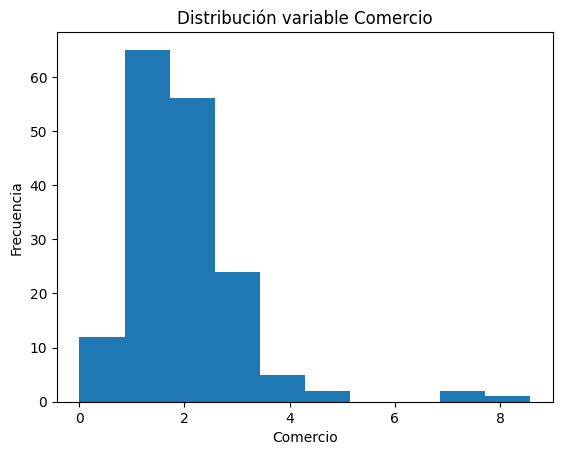

In [11]:
plt.hist(x=Datos['Comercio'], bins=10)
plt.title('Distribución variable Comercio')
plt.xlabel('Comercio')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

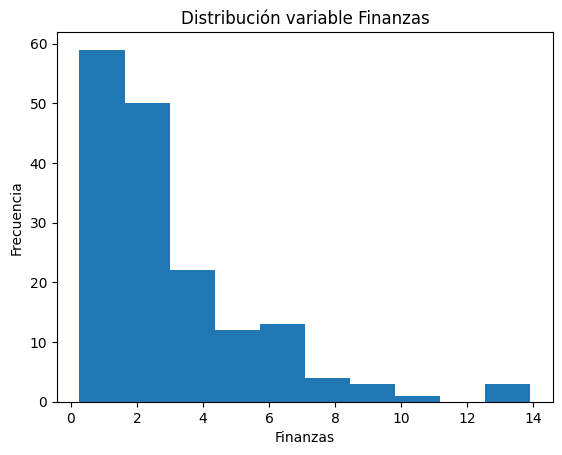

In [12]:
plt.hist(x=Datos['Finanzas'], bins=10)
plt.title('Distribución variable Finanzas')
plt.xlabel('Finanzas')
plt.ylabel('Frecuencia')

Podemos ver que nuestras variables no siguen distribuciones normales, por lo tanto vamos a realizar una normalización de estas tres variables.

In [13]:
scaler=MinMaxScaler()
Datos[['Salud', 'Comercio', 'Finanzas']]=scaler.fit_transform(Datos[['Salud', 'Comercio', 'Finanzas']])

## 4 Entrenamiento y evaluación del modelo

**Ejercicio 3**: Una vez tenemos los datos estandarizados, procedemos a aplicar nuestro método de agrupación.

*  **Selección del algoritmo de clustering**: Argumentar de manera razonada, teniendo en cuenta nuestro problema concreto, que método de agrupación es mejor aplicar en este caso. Existe uno claramente diferenciado.

* **Ajuste de hiperparámetro/s**: Una vez seleccionado el modelo, ajusta los hiperparámetro/s para decidir el o los mejores valores del mismo. Recuerda utilizar todas las técnicas vistas en clase y hacer un análisis completo de la situación para poder tomar la decisión con toda la información disponible. La elección de los valor/es de los hiperparámetros deben estar justificados con gran profundidad y evidencias.

* **Evaluación de la agrupación**: Utiliza métricas vistas en clase y la representación visual de la agrupación final realizada para valorar la calidad de la misma. Usa las librerías 2D y 3D vistas en las prácticas.





Vamos a visualizar la distribución de nuestras tres variables derivadas para elegir el mejor modelo para su clasificación.

In [14]:
fig = go.Figure(data=[go.Scatter3d(
    x=Datos['Salud'],
    y=Datos['Comercio'],
    z=Datos['Finanzas'],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8
    )
)])
fig.update_layout(
    scene=dict(
        xaxis_title='Salud',
        yaxis_title='Comercio',
        zaxis_title='Finanzas'),
    width=700,
    margin=dict(r=20, b=10, l=10, t=10)
)

fig.show()


La distribución de puntos no presenta agrupaciones con formas no esféricas claras, además que no parece que tenga mucho sentido en este caso clasificar a un número importante de países como outliers. Teniendo en cuenta estas dos consideraciones, parece claro que K-means va a ser el algoritmo más adecuado para llevar a cabo la agrupación.

In [15]:
Datos_cluster=Datos[['Salud', 'Comercio', 'Finanzas']]

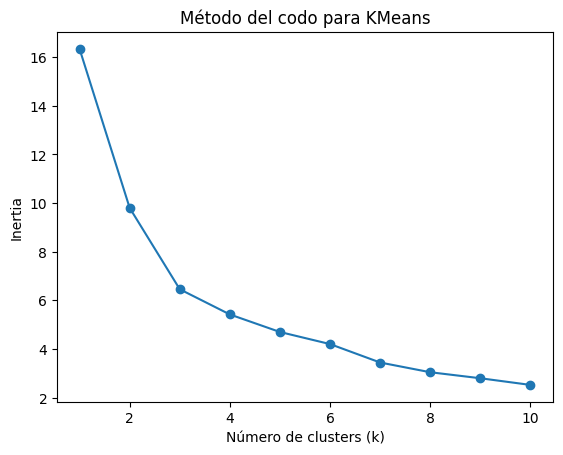

In [16]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Datos_cluster)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del codo para KMeans')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.show()

Con este análisis no queda claro si el mejor valor es 2 o 3. Vamos a representar la silueta media en función de K para salir de dudas.

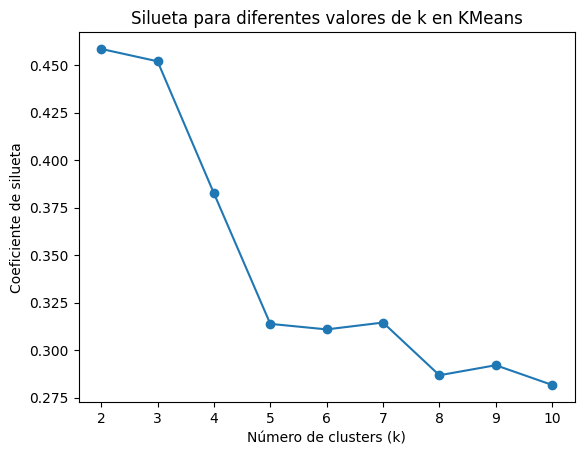

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Rango de valores de k a evaluar
k_values = range(2, 11)

# Inicializamos una lista para almacenar los valores de silueta
silhouette_scores = []

# Calculamos la silueta para cada valor de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Datos_cluster)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(Datos_cluster, labels)
    silhouette_scores.append(silhouette_avg)

# Representamos los valores de silueta
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silueta para diferentes valores de k en KMeans')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Coeficiente de silueta')
plt.show()

Mirando la silueta, parece que el mejor valor de K es 2. Esto, para este caso en específico, parece tener sentido, ya que queremos clasificar entre países desarrollados que no necesitan ayuda, y los países en desarrollo que si la necesitan. Igualmente, el margen entre ambos casos es muy pequeño, con ambas siluetas prácticamente con el mismo valor. Por lo tanto es posible que sea mejor el valor K=3, aunque se sacrifique un poco de calidad de agrupación en forma de ligero descenso de la silueta media, al darnos más divisiones en cuanto a necesidad de ayuda humanitaria.

In [34]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=123)
kmeans.fit(Datos_cluster)
labels = kmeans.labels_

In [35]:


silhouette_avg = silhouette_score(Datos_cluster, labels)
print(f"Coeficiente de silueta: {silhouette_avg}")

Coeficiente de silueta: 0.4476141021793764


<ipython-input-36-2ce273e216aa>:11: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



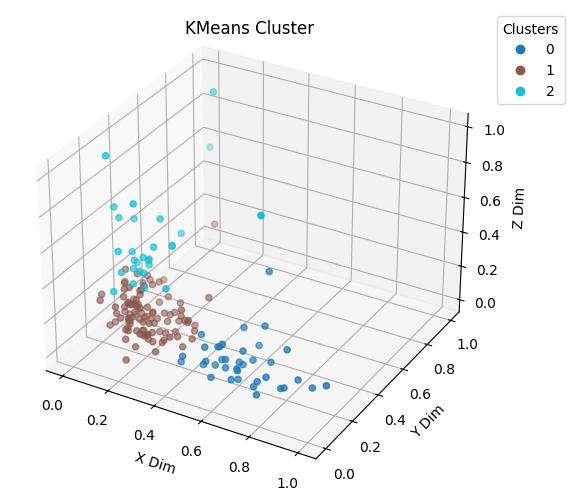

In [36]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure = False)
fig.add_axes(ax)
cmap = ListedColormap(sns.color_palette("tab10").as_hex())
sc = ax.scatter(Datos_cluster['Salud'],Datos_cluster['Comercio'],Datos_cluster['Finanzas'], c = labels, cmap = cmap)
ax.set_xlabel('X Dim')
ax.set_ylabel('Y Dim')
ax.set_zlabel('Z Dim')
plt.legend(*sc.legend_elements(),bbox_to_anchor = (1.17, 1.), title = 'Clusters')
fig.suptitle('KMeans Cluster')
plt.tight_layout()
plt.show()

In [37]:
Datos['cluster'] = labels

In [38]:
cluster_0 = Datos[Datos['cluster'] == 0]['country'].tolist()
cluster_1 = Datos[Datos['cluster'] == 1]['country'].tolist()
cluster_2 = Datos[Datos['cluster'] == 2]['country'].tolist()

In [45]:
print(cluster_2)

['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brunei', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Iceland', 'Ireland', 'Japan', 'Kuwait', 'Luxembourg', 'Mongolia', 'Netherlands', 'Nigeria', 'Norway', 'Oman', 'Qatar', 'Saudi Arabia', 'Singapore', 'Sweden', 'Switzerland', 'United Arab Emirates', 'United Kingdom', 'United States', 'Venezuela']


Vamos a comentar las divisiones llevadas a cabo. El cluster_2 es el correspondiente a los países más desarrollados, estando presente entre ellos Bélgica, Australia, Luxemburgo, entre otros. Es decir, este sería el grupo para el cual la ayuda humanitaria queda completamente descartada. Luego tendríamos el cluser_1, que correspondería a países con un desarrollo algo más moderado, pero que siguen sioendo países desarrollados, como Argentina, Hungria, Italia o Israel, aunque también están presentes países como Uzbekistán o Vietnam. Este grupo sería uno de prioridad media, en el que habría que analizar caso a caso si la ayuda es necesaria. Finalmente, el cluster_0 tiene países como Ángola, Camerún o la República Democrática del Congo. Este sería el grupo de máxima prioridad para la ayuda humanitaria.

**Ejercicio 4**: Interpretar y explicar los resultados obtenidos en base a nuestro problema concreto.

* Desde la ONG se tiene conocimiento de que las variables más representativas para decidir si un país necesita o no ayuda son el ingreso neto (income) y la mortalidad infantil (child_mort). Dibuja un boxplot de ambas variables respecto a los clústeres etiquetados para determinar el nivel de ayuda para cada uno de los diferentes grupos. **Nota**: Si hemos obtenido dos clústers finales, los niveles de ayuda serán (necesita ayuda/no necesita ayuda), si son 3 (no necesita ayuda / necesita ayuda moderada/ necesita mucha ayuda) y así sucesivamente.

*   Utilizando la librería *kaileido* y *plotly.express* **dibuja un mapa mundi** dónde se refleje el nivel de ayuda necesario por país en función de los clústeres realizados. Que cada nivel de ayuda (clúster) tenga un color diferente.


*   **Conclusiones**: En función de nuestro análisis, ¿qué países debería priorizar Ayuda Internacional para depositar su ayuda y sus recursos? ¿Qué mejoras o implementaciones podríamos hacer a este análisis para mejorar sus resultados? Razona las respuestas de manera argumentada.

Vamos a hacer la representación de los ingresos y la mortalidad infantil por clusteres.

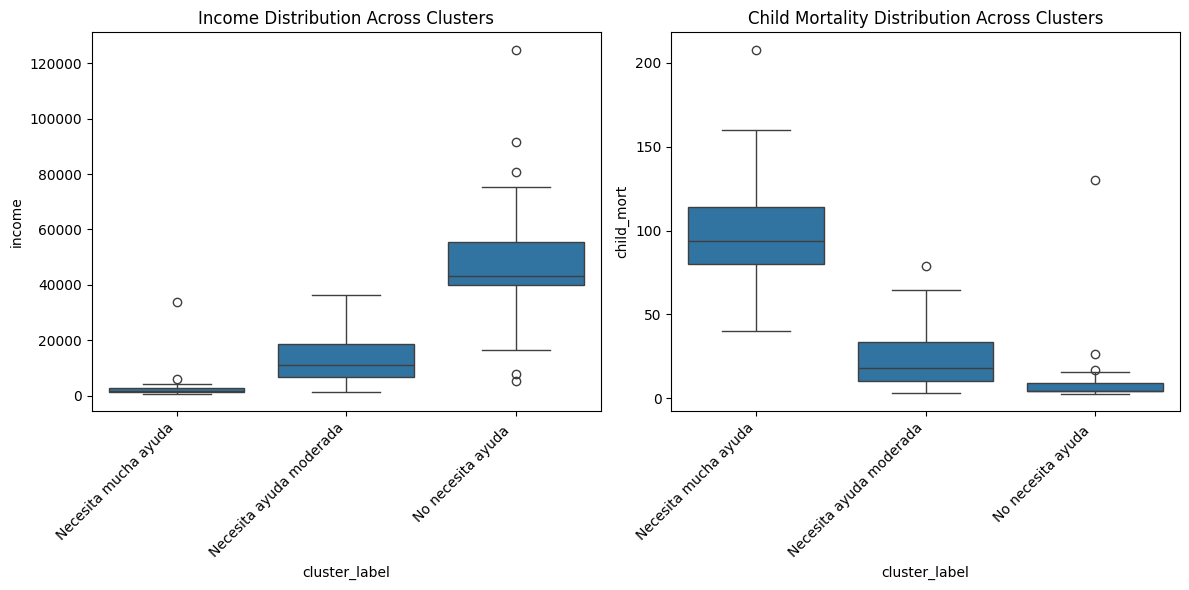

In [46]:
# Definimos la etiqueta de los clusters
cluster_labels = {
    0: "Necesita mucha ayuda",
    1: "Necesita ayuda moderada",
    2: "No necesita ayuda "
}

Datos['cluster_label'] = Datos['cluster'].map(cluster_labels)

plt.figure(figsize=(12, 6))

# Boxplot para la variable 'income'
plt.subplot(1, 2, 1)
sns.boxplot(x='cluster_label', y='income', data=Datos)
plt.title('Income Distribution Across Clusters')
plt.xticks(rotation=45, ha='right')

# Boxplot para la variable 'child_mort'
plt.subplot(1, 2, 2)
sns.boxplot(x='cluster_label', y='child_mort', data=Datos)  # Use 'cluster_label'
plt.title('Child Mortality Distribution Across Clusters')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

In [47]:
# Vamos a colorear el mapa del mundo con los clusters que hemos obtenido.

import plotly.express as px


fig = px.choropleth(
    Datos,
    locations="country",
    locationmode="country names",
    color="cluster_label",
    color_discrete_sequence=["red", "yellow", "green"],
    title="Nivel de Ayuda Necesario por País",
)

fig.update_geos(
    visible=False, resolution=110, scope="world", showcountries=True, countrycolor="black"
)

fig.show()


De estas dos representaciones podemos sacar varias conclusiones. De la primera gráfica, podemos observar que las agrupaciones resultan significativas desde las variables que la ONG designa como críticas. Podemos ver como claramente la mortalidad infantil es más alta para el cluster correspondiente a los países que  necesitan mucha ayuda, y más bajo para los países que no la necesitan, y viceversa con los ingresos. Aún así, existen claros outliers que indican que ciertos países no han sido clasificados correctamente. Viendo el mapa coloreado la clasificación también parece razonable, pero de nuevo parecen existir clasificaciones dudosas, como tener a Venezuela o Nigeria (IDH de 0,711 y 0,539 respectivamente) como un país que no necesita ayuda, mientras que España está como un país que necesita ayuda moderada (IDH de 0,904). Las divisiones por lo tanto resultan indicativas, aunque con ciertos fallos de clasificación. Una de las cosas que se podrían poner en práctica para mejorar la clasificación es la forma en la que creamos las variables 'Finanzas', 'Salud' y 'Comercio'. En el ejercicio se pide explícitamente que sumemos las variables divididas por su media para crear las nuevas variables. Sin embargo, como hemos comentado anteriormente en este ejercicio, resulta que las variables inflación, mortalidad infantil y fertilidad tienen una correlación negativa con el desarrollo del país. Por esto un posible punto de mejora sería crear las variables derivadas de tal manera que restamos estas tres variables divididas por su media en vez de sumarlas. Este fallo en la forma de crear las variables derivadas es seguramente lo que provoca problemas de clasificación como que Venezuela esté clasificada como un país más desarrollado que España, al considerarse la inflación como una variable positiva con respecto a la economía de un país.



## 5 Análisis de resultados y conclusión del problema.

Podemos concluir que la clasificación utilizando K-means da buenos resultados, pero existen algunos fallos de clasificación. Estos fallos sin embargo no deberían deberse al método de clasificación, si no al tratameinto de los datos, e incluso a la falta de datos adicionales que puedan discriminar de mejor manera entre estos países. En conclusión, a pesar de que no hace un mal trabajo K-means, para un número de muetras tan pequeño como este, con 167 países a considerar, y existiendo métricas como el índice de desarrollo humano, seguramente sea mejor analizar los casos uno a uno, y decidir que países deberían recibir ayuda directamente. Así además podriamos tener en cuenta otras peculiaridades que aquí no podemos tener en cuenta, como si están atravesando una crisis o si existe alguna minoría en el apís que está siendo discriminada o que vive en peores condiciones que el resto del país, algo que en este análisis no podemos tener en cuenta.